#import rosbag
#from bagpy import bagreader
#import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [5]:
b = bagreader("/vol/research/eventSSA/collision_avoidance/scene_flow/optical_flow/RWR_dataset/rosbags/left_1/r2l2.bag")
b.topic_table
 
e_msg = b.message_by_topic("/dvs/events") 
events = pd.read_csv(e_msg)

events


NameError: name 'bagreader' is not defined

In [ ]:
# Utils functions
def process_chris_events(events_list: list):
# Process event lists from rosbags to nested lists of events with x, y, sec, nsec and polarity
    events_processed = re.sub(r'\w+:\s?', "", events_list.replace("[","").replace("]","").replace("\n", " ")).split(",")
    events_processed = [[e for e in event.split(" ") if e] for event in events_processed]

    for event in events_processed:
        event[0] = int(event[0])
        event[1] = int(event[1])
        event[2] = int(event[2])
        event[3] = int(event[3])
        event[4] = True if event[4] == "True" else False 

    return events_processed

processed =[]
for i in range(len(events)):
    for event in process_chris_events(events["events"][i]):
        processed.append(event)
    #print(process_chris_events(events["events"][i]))

print(np.array(processed))
print(np.delete(np.array(processed), 2, 1))


plt.scatter(np.array(processed)[:])

[[       134         61 1650884247  150183993          1]
 [        91         73 1650884247  151655993          1]
 [        96         18 1650884247  152147993          0]
 ...
 [       232         78 1650884252  273808993          1]
 [       237        126 1650884252  274413993          1]
 [       126         25 1650884252  274876993          1]]
[[      134        61 150183993         1]
 [       91        73 151655993         1]
 [       96        18 152147993         0]
 ...
 [      232        78 273808993         1]
 [      237       126 274413993         1]
 [      126        25 274876993         1]]


TypeError: scatter() missing 1 required positional argument: 'y'

# EDeNN data preprocess 

In [ ]:
#import numpy as np
from edenn.datasets.angular_velocity import AngularVelocity
from edenn.datasets.utils import SpikeRepresentationGenerator
import matplotlib.pyplot as plt
import torch
import h5py
data = {}
file = "/vol/research/eventSSA/collision_avoidance/scene_flow/optical_flow/code/edenn+/data/test/seq_1.h5"
with h5py.File(file, "r") as hf:
				data["ev_xy"] = torch.from_numpy(hf["ev_xy"][()])
				data["ev_ts_us"] = torch.from_numpy(hf["ev_ts"][()])
				data["ev_pol"] = torch.from_numpy(hf["ev_pol"][()])
				data["ang_xyz"] = torch.from_numpy(hf["ang_xyz"][()])
				data["ang_ts_us"] = torch.from_numpy(hf["ang_ts"][()])

In [ ]:
#%matplotlib notebook
#!pip install ipython
#%matplotlib widget
spikerep = SpikeRepresentationGenerator(width=240, height=180, num_time_bins=100)

spike = spikerep.getSlayerSpikeTensor(
			data["ev_pol"],
			data["ev_xy"],
			data["ev_ts_us"],
		)

print(spike.nonzero().shape)
print(torch.sum(spike[1,:,:,:],2).shape)


for i in range(20):
	plt.figure()
	plt.imshow(torch.sum(spike[1,:,:,i*5:(i+1)*5],2))
#z, x, y = torch.sum(spike[1,:,:,:],2).nonzero().T

#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')

#ax.scatter(x, y, z, c=z, alpha=1)
#for i in range(100):
#    print(spike[:,:,:,i])

In [ ]:
for key in data:
    print(key)

for i in data["ev_ts_us"] :
    print(i)

## EDeC neuron and layer codding

#### 1) online mode (slice per slice)
    1. Apply spatial convolution with kernel to get input potential 
    2. multiply by decay to get decayed potential at t + 1

In [ ]:
# Input slize of the voxelized representation
input_slice = torch.ones((1,2,1,400,400))  # shape ->(B,C,T,H,W) T is time (number of bins)

# Neuron weights and bias
weights = torch.full((1,2,1,3,3), 2, dtype=torch.float) # shape -> (B,C,T,H,W) T is time (number of bins)
bias = torch.tensor([1], dtype=torch.float)

# Neuron decay 
dec = 0.1

# 1. Spatial convolution
convolved_potential = F.conv3d(input_slice,weights,bias)
print(f"convolved potential shape (B,C,T,H,W): {convolved_potential.shape}")
print(convolved_potential)

# 2. Decay step
decayed_potential = convolved_potential * (1 - dec)
print("-"*400)
print(f"decayed potential shape (B,C,T,H,W): {decayed_potential.shape}")
print(decayed_potential)




convolved potential shape (B,C,T,H,W): torch.Size([1, 1, 1, 398, 398])
tensor([[[[[37., 37., 37.,  ..., 37., 37., 37.],
           [37., 37., 37.,  ..., 37., 37., 37.],
           [37., 37., 37.,  ..., 37., 37., 37.],
           ...,
           [37., 37., 37.,  ..., 37., 37., 37.],
           [37., 37., 37.,  ..., 37., 37., 37.],
           [37., 37., 37.,  ..., 37., 37., 37.]]]]])
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
decayed potential shape (B,C,T,H,W): torch.Size([1, 1, 1, 398, 398])
tensor([[[[[33.3000, 33.3000, 33.3000,  ..., 33.3000, 33.3000, 33.3000],
           [33.3000, 33.3000, 33.3000,  ..., 33.3000, 33.3000, 33.3000],

#### 2) dense mode (full volume)
    1. Apply spatial convolution to the input potential.
    2. The decay operation can be applied to the entire volume by:
        - Choosing a time window T.
        - Convolving the volume with a (B,1,T,1,1) filter with B = number of filters in the layer and T = number of time bins. For this you need to add padding in the T dimension at the beginning of your input of lenght T - 1. This filter is populated with the powers of the decay value in the form [d^(T-1), d^(T-2), ... d^0].
            * In the case of just using one spatial filter in the layer, you can think of the kernel as an array of decay values (1,1,T,1,1).
            * If more than one spatial filter present, this same kernel has to be convolved over all the activation maps (potentials) while keeping the results separate. For this, arrange said kernel's copies to be (B,1,T,1,1) as the batch dim also means out channels when used as the weights of a conv3d. then set the groups to B so that each channel is convolved with its own decay filter.  

In [ ]:
# Input slize of the voxelized representation
n_bins = 5
input_slice = torch.ones((2,2,n_bins,400,400))  # shape ->(B,C,T,H,W) T is time (number of bins)

# Neuron weights and bias
n_kernels = 4
weights = torch.full((n_kernels,2,1,3,3), 2, dtype=torch.float) # shape -> (B,C,T,H,W) T is time (number of bins) / B and C in convolutional weights can be thought as out and in channels (see groups)
bias = torch.ones(n_kernels, dtype=torch.float)

# Neuron decay 
dec = np.full([n_kernels],0.1)
print(dec)
print(dec.shape)

# 1. Spatial convolution
convolved_potential = F.conv3d(input_slice,weights,bias)
print(f"convolved potential shape (B,C,T,H,W): {convolved_potential.shape}")
#print(convolved_potential)
# 2. Decay step
# Calculate the decay filter
timesteps = np.arange(n_bins)[::-1] # How many timesteps will the dense mode take into account
dense_timesteps =np.transpose(np.tile(timesteps, (n_kernels,1,))) # repeat the same timesteps per out-channel (per-filter)
print(dense_timesteps)
print(dense_timesteps.shape)

sape = np.transpose((1-dec)**dense_timesteps)
#print(sape)
#print(sape.shape)
#decay_lambda = lambda t: (1-dec)**t # Decay lambda
#decay_filter = [decay_lambda(xi) for xi in dense_timesteps]
#decay_filter.reverse()

decay_filter_tensor = torch.tensor(sape,dtype=torch.float).reshape(n_kernels,1,n_bins,1,1) # Tensor with the decay multiplier for each timestep

#print(decay_filter_tensor)
# Pad input 
padding = (0,0, 0,0, n_bins-1,0, 0,0) # two padding values per dimension, adding padding at the front of T dim
padded_potential = F.pad(convolved_potential, padding, value=0)

print(padded_potential.shape)
# Convolve the output with the decay filter
decayed_potential = F.conv3d(padded_potential,decay_filter_tensor,groups=padded_potential.shape[1])

print(decayed_potential[0,0,3,:,:])
print("-"*20)
print(f"decayed potential shape (B,C,T,H,W): {decayed_potential.shape}")
print(decayed_potential.shape)




#### 3) full forward pass (both cases in one) [old]

In [ ]:
# Neuron decay 
dec = 0.1
# Neuron (spatial) weights and bias
weights = torch.full((1,2,1,3,3), 2, dtype=torch.float) # shape -> (B,C,T,H,W) T is time (number of bins)
bias = torch.tensor([1], dtype=torch.float)


# Neuron state for streaming mode
class edec_neuron():

    def __init__(self):
        self.neuron_state = 0
    def forward(self, x):
        assert len(x.shape) == 5 # (B,C,T,H,W)
        
        # 1. Spatial convolution
        convolved_potential = F.conv3d(x,weights,bias)
        #print(f"convolved potential shape (B,C,T,H,W): {convolved_potential.shape}")

        # 2. Decay step 
        if x.shape[2] == 1: # If only one slice is provided then streaming mode
            if isinstance(self.neuron_state, int):
                # Add current potential to the neuron memory
                output = convolved_potential
                # Decay for next timestep and override the memory (permute to put the T dimension last and multiply by the decay values)
                self.neuron_state = (output.permute(0,2,3,4,1) * (1 - dec)).permute(0,4,1,2,3)
                #print(f"state at t = 0 {self.neuron_state[0,0,0,0,0]}")
            else:
                
                output = convolved_potential + self.neuron_state

                # Decay for next timestep and override the memory (permute to put the T dimension last and multiply by the decay values)
                self.neuron_state = (output.permute(0,2,3,4,1) * (1 - dec)).permute(0,4,1,2,3)
                #print(f"state at t =  {self.neuron_state[0,0,0,0,0]}")
        else: # If more than one slice is provided then dense mode
            # Get number of timesteps provided
            n_bins = x.shape[2] 
            # How many timesteps will the dense mode take into account. Also reverse them so they go from t0 to T.
            timesteps = torch.tensor(np.arange(n_bins)[::-1].copy())
            # repeat the same timesteps per out-channel (per-filter)
            dense_timesteps = torch.t(torch.tile(timesteps, (weights.shape[0],1)))

            # Decay "propagation" to get decay arrays of [dec^(T-1), dec^(T-2), ..., dec^(1), dec^(0)] per filter
            decay_filters = torch.t(torch.pow((1-dec),dense_timesteps))

            # Tensor with the decay multiplier for each timestep. Reshape to (n_filters, 1, T, 1, 1)
            decay_filter_tensor = decay_filters.reshape(weights.shape[0],1,n_bins,1,1) 

            # Pad input 
            padding = (0,0, 0,0, (n_bins-1),0, 0,0) # two padding values per dimension, adding padding at the front of T dim = (T - 1)
            padded_potential = F.pad(convolved_potential, padding, value=0)

            # Convolve the output with the decay filter, if more than one conv filter set the groups param to number of conv filters 
            # so each "activation map" is decayed independently with the appropriate decay values 
            output = F.conv3d(padded_potential,decay_filter_tensor, groups=convolved_potential.shape[1])
        return output

        
    

- Trying the layer

In [ ]:
input_slice = torch.ones((30,2,10,400,400))  # shape ->(B,C,T,H,W) T is time (number of bins)

# Neuron decay 
dec = torch.full([10],0.1)
print(dec)
# Neuron (spatial) weights and bias
weights = torch.full((10,2,1,3,3), 2, dtype=torch.float) # shape -> (B,C,T,H,W) T is time (number of bins)

print(weights.shape)
print(dec.shape)

bias = torch.ones(weights.shape[0], dtype=torch.float)
print(bias.shape)
#hola = edec_neuron()
y = hola.forward(input_slice)
#print(y)
#print(y.shape)
print(y[0,0,0,:,:])

print(input_slice[:,:,1,:,:].unsqueeze(2).shape)

for i in range(5):
   print(hola.forward(input_slice[:,:,i,:,:].unsqueeze(2))[0,0,0,0,0])

In [ ]:


sape = partialDecay3Dx(2, 10, 3)
input_slice = torch.ones((2,2,6,400,400)) 
out = sape(input_slice)
#mask = F.dropout(torch.ones((1,1,1,400,400))) / 2
#print(sape.get_parameter("decay_weight").shape)
#print(sape.get_parameter("spatial_weight").shape)
print(out[0,0,0,0,0])





TypeError: tuple indices must be integers or slices, not tuple

- Masked partial convolutions code 

In [ ]:
print(mask[0,:,:,:,:])
# Input tensor
input_tensor = torch.rand((3,1,3,40,40)) * mask
weight =  torch.full([2,1,1,3,3],2,dtype=torch.float)
decay = torch.full([2], 0.1)

tensor([[[[0., 0., 1.,  ..., 1., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 1.],
          [1., 1., 0.,  ..., 1., 1., 1.],
          ...,
          [1., 0., 1.,  ..., 0., 0., 1.],
          [1., 1., 1.,  ..., 0., 0., 1.],
          [0., 0., 0.,  ..., 1., 1., 0.]],

         [[1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 1.,  ..., 0., 1., 0.],
          [1., 0., 1.,  ..., 0., 0., 1.],
          ...,
          [1., 0., 1.,  ..., 0., 0., 0.],
          [1., 1., 0.,  ..., 1., 1., 1.],
          [1., 0., 1.,  ..., 0., 0., 0.]],

         [[1., 0., 0.,  ..., 0., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 0.],
          [1., 0., 1.,  ..., 0., 1., 0.],
          ...,
          [1., 1., 1.,  ..., 0., 1., 0.],
          [0., 0., 1.,  ..., 0., 0., 1.],
          [1., 0., 0.,  ..., 0., 0., 0.]]]])


In [ ]:


#print(input[1,0,0,:,:])

# 3x3 filter
filter = torch.full([2,2,1,3,3],2,dtype=torch.float)

# masked Convolution operation
conv_output = F.conv3d(input,filter)

#### re-weighting #### 
# Each convolution solution is supposed to be re-weighted by (sum(kernel)/sum(unmasked_kernel))
sum_kernel = torch.sum(filter,dim=[1,2,3,4])
#print(sum_kernel.shape)
print(f"sum of all values in kernel = {sum_kernel}")
sum_unmasked = F.conv3d(mask.repeat(1, filter.shape[1], 1,1,1), filter)
print(mask.repeat(1, filter.shape[1], 1,1,1).shape)
print(sum_unmasked.shape)
# re weighting weights
re_w = (sum_kernel / sum_unmasked.permute(0,2,3,4,1)).permute(0,4,1,2,3)

print(re_w.shape)

# sum with output tensor
re_w_output = conv_output + re_w

#### Create new mask ####
new_mask = torch.clip(sum_unmasked, 0,1)

print(re_w[:,:,:,0,:4])
print(re_w_output[:,:,:,0,:4])
print(new_mask[:,:,:,1,:])
print(conv_output[:,:,:,0,:4])


#TODO (13-12-23):
# pre compute the kernel times decay for dense mode then only one conv.
# Partial conv multiply by re-weighting - Done
# add abs when summing values of kernel in partial conv? - Proof suggests not?
# Once first tests are done add sigmoid to decay before learning !!!!
# Also initialize decays in between 0 and 1 randomly 

#### 4) Testing the reimplementation (+ Original edenn layer)

In [ ]:
#### Imports ####
import re
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from edenn.models.utils.decay3dx import Decay3Dx2, partialDecay3Dx, Decay3Dxloop # re-Implementation#


In [ ]:
from edenn.datasets.utils import EventSlicer, VoxelGrid
import h5py
import torch
from torchvision.transforms.functional import crop
voxel_grid = VoxelGrid((15,480,640),normalize=True)
def events_to_voxel_grid(voxel_grid, p, t, x, y, device: str='cpu'):
    t = (t - t[0]).astype('float32')
    t = (t/t[-1])
    x = x.astype('float32')
    y = y.astype('float32')
    pol = p.astype('float32')
    event_data_torch = {
        'p': torch.from_numpy(pol),
        't': torch.from_numpy(t),
        'x': torch.from_numpy(x),
        'y': torch.from_numpy(y),
    }
    return voxel_grid.convert(event_data_torch)
file = h5py.File("/vol/research/eventSSA/thun_00_a/events/left/events.h5", 'r')

event_s = EventSlicer(file)

events  = event_s.get_events(49600100510, 49600200516)

#print(events)

vox  =events_to_voxel_grid(voxel_grid, events["p"], events["t"],events["x"],events["y"])

c_x = 384 # width of crop
c_y = 288 # height of crop

original_x = 640
original_y = 480

max_x = original_x - c_x
max_y = original_y - c_y

print(max_x)
print(max_y)
print(crop(vox,192,256,288,400).shape)

print(crop(vox,192,256,288,400)[:,:,:-10])

256
192
torch.Size([15, 288, 400])
tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000, -0.2137, -0.2564,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000, -0.8312, -0.7885,  ...,  0.0000,  0.0000,  0.0000],
         [

In [ ]:
# Dummy mask and input
mask = F.dropout(torch.ones((3,1,3,40,40))) / 2
input_tensor = torch.rand((3,1,3,40,40))

In [ ]:
# Testing dense vs streaming mode in naive decay version (looping through timesteps)
sapenet = Decay3Dxloop(1,10,3)

out = sapenet(input_tensor, mask)

for i in range(3):
    print("="*60)
    print(f"dense (t{i})")
    print(out[0][0,0,i,:5,:5].detach())
    print(f"Streaming (t{i})")
    print(sapenet(input_tensor[:,:,i,:,:].unsqueeze(1),mask[:,:,i,:,:].unsqueeze(1))[0][0,0,0,:5,:5].detach())

In [ ]:
# Testing dense vs streaming mode in efficient version (decaying spatial filter)
sapenet = Decay3Dx2(1,10,3)

out = sapenet(input_tensor, mask)

for i in range(3):
    print("="*60)
    print(f"dense (t{i})")
    print(out[0][0,0,i,:5,:5].detach())
    print(f"Streaming (t{i})")
    print(sapenet(input_tensor[:,:,i,:,:].unsqueeze(1),mask[:,:,i,:,:].unsqueeze(1))[0][0,0,0,:5,:5].detach())

- Testing GPU memory usage of layer

In [ ]:
## TESTING EFFICIENT ## 
print(f"GPU mem used at the beginning: \n { torch.cuda.memory_allocated(0)}")
# Dummy mask and input
mask = (F.dropout(torch.ones((16,1,15,400,600))) / 2).to("cuda:0")
input_tensor = torch.rand((16,2,15,400,600)).to("cuda")
print(f"GPU mem used after variables: \n { torch.cuda.memory_allocated(0) *1e-9}")

sapenet = Decay3Dx2(2,10,3).to("cuda")
print(f"GPU mem used after initialising model: \n { torch.cuda.memory_allocated(0) * 1e-9}")

out = sapenet(input_tensor, mask)
print(f"GPU mem used after forward: \n { torch.cuda.memory_allocated(0) * 1e-9}")
torch.cuda.empty_cache()
print(f"GPU mem used after empty cache: \n { torch.cuda.memory_allocated(0) * 1e-9}")

In [ ]:
## TESTING NAIVE ## 
print(f"GPU mem used at the beginning: \n { torch.cuda.memory_allocated(0)}")
# Dummy mask and input
mask = (F.dropout(torch.ones((16,1,15,400,600))) / 2).to("cuda:0")
input_tensor = torch.rand((16,2,15,400,600)).to("cuda")
print(f"GPU mem used after variables: \n { torch.cuda.memory_allocated(0) *1e-9}")

sapenet = Decay3Dxloop(2,10,3).to("cuda")
print(f"GPU mem used after initialising model: \n { torch.cuda.memory_allocated(0) * 1e-9}")

out = sapenet(input_tensor, mask)
print(f"GPU mem used after forward: \n { torch.cuda.memory_allocated(0) * 1e-9}")
torch.cuda.empty_cache()
print(f"GPU mem used after empty cache: \n { torch.cuda.memory_allocated(0) * 1e-9}")

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from edenn.models.utils.decay3dx import Decay3Dx2, partialDecay3Dx, Decay3Dxloop# re-Implementation
from edenn.models.utils.decay3d import Decay3Dfixed # Original edenn with fixed weights for testing
import time
T = 30
input_events = torch.ones((20,2,T,640,480))

#print(input_events[:,:,1].shape)
loop = Decay3Dxloop(2,10,3)
old = Decay3Dx2(2,10,3)
sape = partialDecay3Dx(2,10,3)

start = time.time()
new = sape(input_events)
end = time.time()

print(f"elapsed time 2 convolutions: {end - start}s")

start = time.time()
new_out = loop(input_events)
end = time.time()

print(f"elapsed time loop: {end - start}s")

start = time.time()
out_new = old(input_events)
end = time.time()

print(f"elapsed time efficient: {end - start}s")



#### 5) Loading event data and pre-processing (DSEC)

In [ ]:
# Imports for loading data
import h5py
import numpy as np 
import torch

In [ ]:
# Load hdf5 events file
f = h5py.File("/vol/research/eventSSA/thun_00_a/events/left/events.h5", "r")

# load events dataset inside file
event_dataset = f["events"]
dic_dataset = {}


print(f"hdf5 keys: {list(f.keys())}")
# use events keys to extract polarity, timestamps, x and y
for key in event_dataset.keys(): # p, t, x, y
    dic_dataset[key] = np.asarray(event_dataset[key])

# Also extract ms to idx and timestamp offset so events are aligned with frames?
ms_idx = np.asarray(f["ms_to_idx"], dtype="int64")
t_offset = int(f["t_offset"][()])


hdf5 keys: ['events', 'ms_to_idx', 't_offset']


In [ ]:
from edenn.datasets.utils import EventSlicer, VoxelGrid
from edenn.datasets.dsec import Sequence, SequenceEDENN
# Imports for loading data
import h5py
import numpy as np 
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import imageio
import os 
sequence_file = h5py.File("/vol/research/eventSSA/thun_00_a/events/left/events.h5", "r")

root_path = Path("/vol/research/eventSSA/thun_00_a/")
s_name = "sape"

sequence = SequenceEDENN(root_path,s_name)
sample = sequence[1]


OSError: /vol/research/eventSSA/thun_00_a/train_optical_flow/sape/flow/forward_timestamps.txt not found.

In [1]:
from edenn.models.utils.decay3dx import Decay3Dx2
import torch
import torch.nn as nn
import torch.cuda.amp


#import 
layer = Decay3Dx2(1, 3, 3, padding = 1, n_bins = 4).to("cuda")
maxpool = nn.MaxPool3d((1,2,2))
upsample = nn.Upsample(scale_factor = (1,2,2), mode = "trilinear")




mask = torch.heaviside(torch.nn.Dropout()(torch.rand(2,1,10,203,215)) / 2, torch.tensor(0, dtype= torch.float)).to("cuda")
print(mask.shape)
input = torch.rand(2,2,10,203,215).to("cuda")
Gt = torch.rand(3,5,30,30)

torch.Size([2, 1, 10, 203, 215])


## Piecewise build of u-denn tests

#### 1) Single decay3dx2 vs conv3d 

In [1]:
from edenn.models.edenn_plus import Udenn
from edenn.models.utils.decay3dx import Decay3Dx2test, Decay3Dxloop, Decay3Dx2, Decay3Dx2new, Decay3Dx2newdense, Decay3dPartialC
import torch
import torch.nn as nn

#input = torch.rand(2,2,20,288,300).to("cuda")
input = torch.rand(2,2,4,288,300).to("cuda")
#mask = torch.heaviside(torch.nn.Dropout(0.2)(torch.rand(2,1,4,288,300)) / 2, torch.tensor(0, dtype= torch.float)).to("cuda")
#mask = torch.ones(2,1,4,288,300).to("cuda")
#print(mask.shape)
#print(mask)
Gt = torch.rand(2,3,4,288,300).to("cuda")
#model = Decay3Dxloop(2, 3, 3, padding = 0, n_bins = 20).to("cuda")
##model = Decay3Dx2(1, 3, 3, padding = 0, n_bins = 4).to("cuda")

In [2]:
#mask = torch.ones(2,1,4,288,300).to("cuda")
mask = torch.heaviside(torch.nn.Dropout(0.8)(torch.rand(2,1,4,288,300)) / 2, torch.tensor(0, dtype= torch.float)).to("cuda")

In [5]:
import matplotlib.pyplot as plt
import numpy as np 
task_loss = nn.MSELoss()
#out = torch.mean(model(input,mask)[0])
conv = torch.nn.Conv3d(2,3,3, padding=1,stride=1).to("cuda")
task_optimizer = torch.optim.SGD(conv.parameters(), lr=0.01)
layer = Decay3Dx2test(2, 3, 3, padding = 1, n_bins = 4).to("cuda")
batchnorm = torch.nn.BatchNorm3d(3).to("cuda")

#print(list(layer.parameters()))
decay_optim = torch.optim.Adam(list(layer.parameters()), lr=0.01)# + list(batchnorm.parameters()), lr=0.01)


means = np.arange(1,2,step=0.5)

max_grad = 400

print(0)
# for i in range(300):


#     output  = conv(input*mask)

#     #print(output.shape)

#     loss = task_loss(output, Gt)

#     loss.backward()
#     task_optimizer.step()
#     task_optimizer.zero_grad()

#     print(f"(loss): {loss.item()}")


# print("= decay3dx" + "="*100)


decay_loss = []


for i in means[:1]:
    print("="*100)
    print(f"mean: {i}")
    layer = Decay3Dx2new(2, 3, 3, padding = 1).to("cuda")
    #torch.nn.init.normal_(layer.spatial_weight, mean=i, std=0.5)

    
    #print(list(layer.parameters())[1].shape)

    decay_optim = torch.optim.Adam(list(layer.parameters()), lr=0.01)
    for i in range(600):



        #print(input.shape)
        #print(mask.shape)
        output  = layer(input)[0]#,mask.repeat(1,2,1,1,1))[0]
        print(f"mean {list(layer.parameters())[0].mean()}")
        #output = batchnorm(output)

        # if (i % 50) == 0:
        # for i in range(input.shape[2]):         
        #     print(f"timestamp {i} mean: {output[0,:,i,:,:].mean()}")
        #     print(f"timestamp {i} min: {output[0,0,i,:,:].min()}")
        #     print(f"timestamp {i} max: {output[0,:,i,:,:].max()}")
        #     #print(f"timestamp {i} max: {torch.where(output[0,:,i,:,:] == output[0,:,i,:,:].max())}")


        # if i ==0:
        #     print(output[0,0,-1,:20,:20])
        # elif i == range(600)[-1]:
        #     print(output[0,0,-1,:20,:20])


        #print(output.shape)

        loss = task_loss(output, Gt)




        loss.backward()
        # spatial_grads = list(layer.parameters())[0].grad
        # print(f"spatial_grad: {spatial_grads[:,:,0,:,:]}")
        # #torch.nn.utils.clip_grad_norm_(layer.parameters(), max_grad)
        # spatial_grads = list(layer.parameters())[0].grad
        # print(f"spatial_grad: {spatial_grads[:,:,0,:,:]}")

        #print(layer.spatial_weight.grad)

        # if loss.item() < 4:
        #     for i in range(input.shape[2]): 
        #         print(f"timestamp {i} mean: {output[0,:,i,:,:].mean()}")
        #         print(f"timestamp {i} min: {output[0,0,i,:,:].min()}")
        #         print(f"timestamp {i} max: {output[0,:,i,:,:].max()}")
        #         print(f"timestamp {i} max: {torch.where(output[0,:,i,:,:] == output[0,:,i,:,:].max())}")

            # print(output[0,0,-1,:20,:20])
            # print(f"(loss): {loss.item()}")
            # break

        decay_optim.step()
        decay_optim.zero_grad()

        decay_loss.append(loss.item())

        #decay.loss
        print(f"(loss): {loss.item()}")

    # break


# plt.figure()
# plt.plot(decay_loss)


0
mean: 1.0
mean -0.001685597817413509
(loss): 0.443069189786911
mean -0.008722631260752678
(loss): 0.32465440034866333
mean -0.014180977828800678
(loss): 0.23554760217666626
mean -0.02080373466014862
(loss): 0.1747259944677353
mean -0.02710855007171631
(loss): 0.14031168818473816
mean -0.0322648324072361
(loss): 0.12795157730579376
mean -0.036472003906965256
(loss): 0.13157609105110168
mean -0.040072228759527206
(loss): 0.14351126551628113
mean -0.04294105991721153
(loss): 0.15660710632801056
mean -0.04465559870004654
(loss): 0.16600577533245087
mean -0.045066602528095245
(loss): 0.1693219542503357
mean -0.04447292163968086
(loss): 0.16662877798080444
mean -0.043337542563676834
(loss): 0.15935435891151428
mean -0.04188578575849533
(loss): 0.14952392876148224
mean -0.04003198817372322
(loss): 0.13929274678230286
mean -0.037706684321165085
(loss): 0.1303028166294098
mean -0.035112377256155014
(loss): 0.12365305423736572
mean -0.03261828050017357
(loss): 0.11975997686386108
mean -0.03045

In [4]:
centraly = torch.where(output[0,:,0,:,:] == output[0,:,0,:,:].max())[1]
centralx = torch.where(output[0,:,0,:,:] == output[0,:,0,:,:].max())[2]
channel = torch.where(output[0,:,0,:,:] == output[0,:,0,:,:].max())[0]
output_patch = output[0,channel,0,centraly-1:centraly+2, centralx-1:centralx+2].cpu()
print(f"output: {output_patch}")
print("="*100)
input_neighbourhood = input[0,:,0,centraly-1:centraly+2, centralx-1:centralx+2]
print(f"input neighbourhood: {input_neighbourhood}")
# print(f"input neighbourhood c = 1: {input[0,1,0,centraly-1:centraly+2, centralx-1:centralx+2]}")
print("="*100)
mask_neighbouhood = mask[0,0,0,centraly-1:centraly+2, centralx-1:centralx+2]
print(f"input mask: {mask_neighbouhood}")
print("="*100)
spatial_w = list(layer.parameters())[0][channel,:,0,:,:]
print(f"spatial-weight: {spatial_w}")
#print(f"spatial-weight c = 1: {list(layer.parameters())[0][channel,1,0,:,:]}")

bias = list(layer.parameters())[channel]
print(f"bias: {bias}")


print("="*100)
spatial_grads = layer.spatial_weight.grad
print(f"spatial_grad: {spatial_grads[channel,:,0,:,:]}")
decay_grad = layer.decay_weight.grad
print(f"decay_grad: {decay_grad}")





output: tensor([[[ 0.0241,  0.4707],
         [ 0.1199,  0.9657],
         [-0.0181,  0.2107]]], grad_fn=<ToCopyBackward0>)
input neighbourhood: tensor([[[0.9756, 0.3678],
         [0.8422, 0.3639],
         [0.9022, 0.1844]],

        [[0.9719, 0.1619],
         [0.0848, 0.9488],
         [0.8116, 0.0631]]], device='cuda:0')
input mask: tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0')


IndexError: too many indices for tensor of dimension 1

In [9]:
print(f"output masked convolution: {torch.mul(input_neighbourhood*mask_neighbouhood, spatial_w).sum().item()}")
print(f"output convolution: {torch.mul(input_neighbourhood, spatial_w).sum().item()}")


print(f"output/output_mmasked = {torch.mul(input_neighbourhood, spatial_w).sum().item()/torch.mul(input_neighbourhood*mask_neighbouhood, spatial_w).sum().item()}")


masked_spat = torch.mul(mask_neighbouhood,spatial_w)
print(masked_spat)

print(f"sum_kernel: {torch.sum(spatial_w).item()}")

print(f"sum_positive: {torch.sum(torch.nn.functional.relu(spatial_w)).item()}")
print(f"sum_negative: {-1 * torch.sum(torch.nn.functional.relu(-1*spatial_w)).item()}")

print(f"sum_positive_unmasked: {torch.sum(torch.nn.functional.relu(masked_spat)).item()}")
print(f"sum_negative_unmasked: {-1 * torch.sum(torch.nn.functional.relu(-1*masked_spat)).item()}")#

print(f"sum_unmasked: {torch.sum(masked_spat).item()}")

print(f"mean_kernel: {(spatial_w).mean()}")
print(f"mean_unmasked: {(masked_spat).mean()}")


print(f"sum_kernel/sum_unmasked: {torch.sum(spatial_w).item()/torch.sum(masked_spat).item()}")
print(spatial_w.abs())
print(f"(sum_kernel/sum_unmasked)/mean_kernel: {(torch.sum(spatial_w).item()/torch.sum(masked_spat).item())/torch.sum(spatial_w.abs())}")
print(f"re_weighted output: {torch.mul(input_neighbourhood*mask_neighbouhood, spatial_w).sum().item() *((torch.sum(spatial_w).item())/(torch.sum(masked_spat).item())) }")


output masked convolution: 0.01861513778567314
output convolution: 0.9854806661605835
output/output_mmasked = 52.939746001721446
tensor([[[[ 0.0000,  0.0000, -0.0000],
          [ 0.0000, -0.0000,  0.0000],
          [ 0.0212,  0.0000,  0.0000]],

         [[ 0.0000, -0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [-0.0203,  0.0000,  0.0000]]]], device='cuda:0',
       grad_fn=<MulBackward0>)
sum_kernel: 3.269861936569214
sum_positive: 4.476117134094238
sum_negative: -1.2062550783157349
sum_positive_unmasked: 0.02122596837580204
sum_negative_unmasked: -0.020331770181655884
sum_unmasked: 0.0008941981941461563
mean_kernel: 0.18165899813175201
mean_unmasked: 4.967767745256424e-05
sum_kernel/sum_unmasked: 3656.753008421706
tensor([[[[0.1494, 0.2982, 0.4069],
          [0.0140, 0.5375, 0.0045],
          [0.0212, 0.3252, 0.5839]],

         [[0.2409, 0.2415, 0.9819],
          [0.0110, 0.9267, 0.0035],
          [0.0203, 0.5917, 0.3240]]]], device='cuda:0', grad_fn=<AbsB

In [6]:

for i in range(600):

    
    output  = layer(input,mask)[0]
    #output = batchnorm(output)

    # for i in range(input.shape[2]):         
    #     print(f"timestamp {i} mean: {output[0,:,i,:,:].mean()}")
    #     print(f"timestamp {i} min: {output[0,0,i,:,:].min()}")
    #     print(f"timestamp {i} max: {output[0,:,i,:,:].max()}")
    #     print(f"timestamp {i} max: {torch.where(output[0,:,i,:,:] == output[0,:,i,:,:].max())}")

        
    if i ==0:
        print(output[0,0,-1,:20,:20])
    elif i == range(600)[-1]:
        print(output[0,0,-1,:20,:20])


    #print(output.shape)

    loss = task_loss(output, Gt)

    loss.backward()
    decay_optim.step()
    decay_optim.zero_grad()

    decay_loss.append(loss.item())

    #decay.loss
    print(f"(loss): {loss.item()}")
    


tensor([[13.7602, 14.1791, 16.2853, 12.1099, 11.8491, 12.5474, 12.7501, 15.5823,
         13.8593, 14.2256, 14.8291, 18.2128, 15.4996, 13.5617, 11.8859, 10.8499,
          9.3468,  9.7219, 13.9393, 14.0176],
        [13.2915, 14.3657, 17.8595, 15.6899,  9.7578, 14.7646, 13.5665, 14.0994,
         12.5121, 13.9909, 15.1119, 16.9222, 13.3634, 11.9313, 10.1776,  9.4963,
         10.9754,  9.9140, 11.6378, 16.0075],
        [16.0005, 15.8892, 16.0682, 17.0300, 13.1704, 15.3101, 13.6231, 15.0837,
         13.4283, 13.1360, 14.1989, 17.4005, 12.5101, 10.1810,  9.8517,  9.8621,
         11.6643, 12.8625, 12.1471, 12.4002],
        [12.8454, 16.5870, 16.2035, 17.7427, 15.6473, 17.2144, 17.0257, 16.4507,
         19.1993, 16.0617, 12.5417, 12.1522,  8.9969, 11.9751, 11.6383, 11.8919,
         11.9635, 11.0860, 14.3441, 12.9762],
        [16.3487, 16.5147, 17.4896, 17.0383, 17.7940, 14.6172, 17.1704, 16.1454,
         18.4382, 15.9654, 13.7955, 15.3706, 14.0798, 13.2783, 14.5130,  9.3196,
      

In [6]:
decay_loss = []
decay_optim = torch.optim.Adam(layer.parameters(), lr=0.001)
for i in range(4000):

    
    output  = layer(input,mask)[0]

    #print(output.shape)

    loss = task_loss(output, Gt)

    loss.backward()
    decay_optim.step()
    decay_optim.zero_grad()

    #decay.loss
    print(f"(loss): {loss.item()}")


(loss): 1.3182145357131958
(loss): 1.3127251863479614
(loss): 1.3070001602172852
(loss): 1.3015038967132568
(loss): 1.2963086366653442
(loss): 1.2913818359375
(loss): 1.2866849899291992
(loss): 1.2821922302246094
(loss): 1.2779016494750977
(loss): 1.2738256454467773
(loss): 1.2699693441390991
(loss): 1.2663167715072632
(loss): 1.2628333568572998
(loss): 1.259489893913269
(loss): 1.2562803030014038
(loss): 1.253202199935913
(loss): 1.2502440214157104
(loss): 1.2473859786987305
(loss): 1.2446118593215942
(loss): 1.2419114112854004
(loss): 1.239283561706543
(loss): 1.2367252111434937
(loss): 1.2342345714569092
(loss): 1.2318073511123657
(loss): 1.229439377784729
(loss): 1.2271299362182617
(loss): 1.2248762845993042
(loss): 1.2226800918579102
(loss): 1.2205408811569214
(loss): 1.218459963798523
(loss): 1.2164359092712402
(loss): 1.2144668102264404
(loss): 1.2125508785247803
(loss): 1.2106857299804688
(loss): 1.2088687419891357
(loss): 1.2070963382720947
(loss): 1.205365538597107
(loss): 1.

#### 1) 2 decay3dx2 vs 2 conv3d

In [ ]:
padding = (0,0, 0,0, 0,(30-1), 0,0) # two padding values per dimension, adding padding at the back of T dim = (T - 1)
padding2 = (0,0, 0,0, (30*2-1),0, 0,0)
padded_extended_spatial_kernel = F.pad(torch.ones(2,2,3,288,300), padding, value=0)
padded_potential = F.pad(decayed_spatial_kernel, padding2, value=None)

In [ ]:
input = torch.rand(2,5,30,30).unsqueeze(0)
print(f"input shape: {input.shape}")
print(layer(input)[0].shape)
output = maxpool(layer(input)[0])
print(f"encoder shape: {output.shape}")
dec = upsample(layer(output)[0])
print(f"decoder shape: {dec.shape}")

input shape: torch.Size([1, 2, 5, 30, 30])
torch.Size([1, 2, 5, 30, 30])
encoder shape: torch.Size([1, 2, 5, 15, 15])
decoder shape: torch.Size([1, 2, 5, 30, 30])


In [7]:
# todo:
#   - make script that 
input_t = torch.tensor([[2,2,2],
                        [2,2,2],
                        [2,2,2]])


k_t = torch.tensor([[2,-12,2],
                        [4,4,-40],
                        [6,6,6]])


mask_t = torch.tensor([[1,0,1],
                        [1,1,0],
                        [1,1,1]])




masked_t = input_t * mask_t


print(f"masked input: {masked_t}")
print("="*60)
print(f"output conv non_masked: {torch.mul(input_t,k_t).sum()}")
print(f"output conv masked: {torch.mul(masked_t,k_t).sum()}")
print("="*60)
print(f"sum_kernel: {k_t.sum()}")
print(f"sum_unmasked: {(k_t * mask_t).sum()}")
print(f"re_w: {k_t.sum()/(k_t * mask_t).sum()}")


print("="*60)
print(f"sum_kernel (abs): {k_t.abs().sum()}")
print(f"sum_unmasked (abs): {(k_t.abs() * mask_t.abs()).sum()}")

#print(f"re_w (abs): {(k_t.abs().sum()/(k_t.abs() * mask_t.abs()).sum()) * torch.mean(k_t)}")


print(f"re_w (abs): {(k_t * mask_t).float().mean() * ((mask_t - 1).abs() * k_t).sum()}")

print(f"output = {((masked_t).float().sum()/ mask_t.sum()) * ((mask_t - 1).abs() * k_t).float().sum() + torch.mul(masked_t,k_t).sum()}")
print(f"output (fullI) = {((input_t).float().sum()/ 9) * ((mask_t - 1).abs() * k_t).float().sum() + torch.mul(masked_t,k_t).sum()}")

print(f"re_w (abs+new): {1 + (((mask_t - 1).abs() * k_t)).abs().sum()/(k_t.abs().sum())}")



masked input: tensor([[2, 0, 2],
        [2, 2, 0],
        [2, 2, 2]])
output conv non_masked: -44
output conv masked: 60
sum_kernel: -22
sum_unmasked: 30
re_w: -0.7333333492279053
sum_kernel (abs): 82
sum_unmasked (abs): 30
re_w (abs): -173.3333282470703
output = -44.0
output (fullI) = -44.0
re_w (abs+new): 1.6341463327407837


#### X) visualize model outputs (flow)

In [1]:
# Imports
import numpy 
import numpy as np
import io
import torch
from matplotlib import pyplot as plt
from matplotlib import colors
from PIL import Image
import cv2
import imageio
import torch.nn.functional as F
from pathlib import Path

from edenn.datasets.dsec import SequenceEDENN
from edenn.models.edenn_plus import Udenn, Udenn_n, Udenn_nDense, Udenn_nopart

In [2]:
# Helper functions
def flow_16bit_to_float(flow_16bit: np.ndarray):
    # This is necessary, read the DSEC documentation to know why
    assert flow_16bit.dtype == np.uint16
    assert flow_16bit.ndim == 3
    h, w, c = flow_16bit.shape
    assert c == 3

    valid2D = flow_16bit[..., 2] == 1
    assert valid2D.shape == (h, w)
    # ~ means bit inverting
    assert np.all(flow_16bit[~valid2D, -1] == 0)
    valid_map = np.where(valid2D)

    # to actually compute something useful:
    flow_16bit = flow_16bit.astype('float')

    # Only convert to 
    flow_map = np.zeros((h, w, 2))
    flow_map[valid_map[0], valid_map[1], 0] = (flow_16bit[valid_map[0], valid_map[1], 0] - 2 ** 15) / 128
    flow_map[valid_map[0], valid_map[1], 1] = (flow_16bit[valid_map[0], valid_map[1], 1] - 2 ** 15) / 128
    return flow_map, valid2D




def visualize_optical_flow(flow, savepath=None, return_image=False, text=None, scaling=None):
    # flow -> numpy array 2 x height x width
    # 2,h,w -> h,w,2
    flow = flow.transpose(1,2,0)
    flow[numpy.isinf(flow)]=0
    # Use Hue, Saturation, Value colour model
    hsv = numpy.zeros((flow.shape[0], flow.shape[1], 3), dtype=float)

    # The additional **0.5 is a scaling factor
    mag = numpy.sqrt(flow[...,0]**2+flow[...,1]**2)**0.5

    ang = numpy.arctan2(flow[...,1], flow[...,0])
    ang[ang<0]+=numpy.pi*2
    hsv[..., 0] = ang/numpy.pi/2.0 # Scale from 0..1
    hsv[..., 1] = 1
    if scaling is None:
        hsv[..., 2] = (mag-mag.min())/(mag-mag.min()).max() # Scale from 0..1
    else:
        mag[mag>scaling]=scaling
        hsv[...,2] = mag/scaling
    rgb = colors.hsv_to_rgb(hsv)
    # This all seems like an overkill, but it's just to exactly match the cv2 implementation
    bgr = numpy.stack([rgb[...,2],rgb[...,1],rgb[...,0]], axis=2)
    plot_with_pyplot = False
    if plot_with_pyplot:
        fig = plt.figure(frameon=False)
        plot = plt.imshow(bgr)
        plot.axes.get_xaxis().set_visible(False)
        plot.axes.get_yaxis().set_visible(False)
    if text is not None:
        plt.text(0, -5, text)

    if savepath is not None:
        if plot_with_pyplot:
            fig.savefig(savepath, bbox_inches='tight', dpi=200)
            plt.close()
        else: #Plot with skimage
            out = bgr*255
            io.imsave(savepath, out.astype('uint8'))
    return bgr, (mag.min(), mag.max())




In [3]:
import os
root_folder = "/vol/research/datasets/DSEC"
# Names of the sequences that do have GT flow
seq_names = os.listdir(os.path.join(root_folder, "train_optical_flow"))
print(seq_names[14:])

['zurich_city_05_a', 'zurich_city_02_e', 'zurich_city_06_a', 'zurich_city_07_a']


In [6]:
# Data related
#-------------------------------------------------------------------------------------------
root_folder = "/vol/research/datasets/DSEC/"
sample = "zurich_city_02_e"
dataset = SequenceEDENN(Path(root_folder),sample,num_bins=15, crop_window=(288, 384))
datapoint = dataset[0]
input_mask = torch.heaviside(torch.abs(datapoint["events"]), torch.tensor(0, dtype= datapoint["events"].dtype))


# model related
#-------------------------------------------------------------------------------------------
#cpt_path = "/vol/research/eventSSA/weka_checkpoints/new_rw_fast/Udenn_nr_only+DSEC-flow=0.0003.pth"
cpt_path = "/vol/research/eventSSA/new_rw_second/Udenn_nr_only+DSEC-flow=0.0003.pth"
model = Udenn_n(1,2,15)
# Load checkpoint file 
checkpoint = torch.load(cpt_path)
print(checkpoint["current_epoch"])
model.load_state_dict(checkpoint['model_checkpoint'])
model.eval()


model_n = Udenn_nopart(1,2,15)

model_n


5


Udenn_nopart(
  (enc_1): Decay3Dx2_no_partial()
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_2): Decay3Dx2_no_partial()
  (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_3): Decay3Dx2_no_partial()
  (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_4): Decay3Dx2_no_partial()
  (bn4): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (dec_1): upconv_agnostic(
    (decay3dlayer): Decay3Dx2_no_partial()
    (upsample): Upsample(scale_factor=(1.0, 2.0, 2.0), mode=trilinear)
    (upsample_mask): Upsample(scale_factor=(1.0, 2.0, 2.0), mode=nearest)
  )
  (bnd1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec_2): upconv_agnostic(
    (decay3dlayer): Decay3Dx2_no_partial()
    (

In [19]:
print(datapoint["events"].unsqueeze(0).unsqueeze(0).shape)
print(input_mask.shape)
output = model(datapoint["events"].unsqueeze(0).unsqueeze(0), input_mask.unsqueeze(0).unsqueeze(0))

torch.Size([1, 1, 15, 288, 384])
torch.Size([15, 288, 384])


(288, 384, 3)


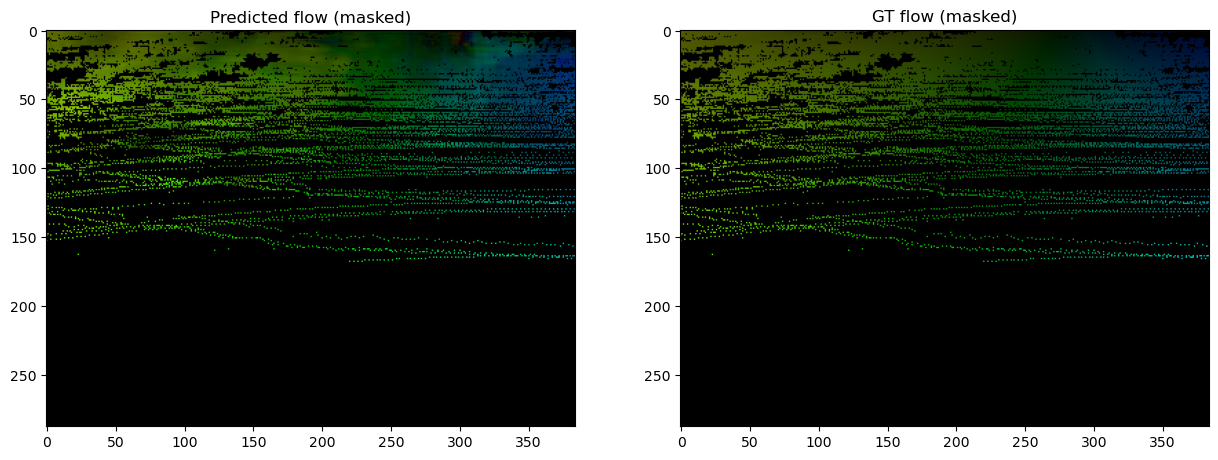

In [13]:
#print(output[0][0,:,-1,:,:].permute(1,2,0).detach().numpy().shape)

flow = visualize_optical_flow(output[0][0,:,-1,:,:].detach().numpy())[0]
print(flow.shape)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 11))
#axes.axhspan

axes[0].set_title("Predicted flow (masked)")
axes[1].set_title("GT flow (masked)")
axes[0].imshow(visualize_optical_flow(output[0][0,:,-1,:,:].detach().numpy() * datapoint["flow"][1].numpy())[0])
axes[1].imshow(visualize_optical_flow(datapoint["flow"][0].permute(2,0,1).numpy() * datapoint["flow"][1].numpy())[0])
# plt.
# plt.figure()
# plt.imshow(visualize_optical_flow(datapoint["flow"][0].permute(2,0,1).numpy() * datapoint["flow"][1].numpy())[0])

#### s) new re-weighting value caculation 

In [84]:
# re_weighting = mean(unmasked_input_elements) * sum(masked_kernel_elements)
input_tensor = torch.full([1,2,4,200,300], 2).float()
input_mask = torch.heaviside(torch.nn.Dropout(0.5)(torch.rand(1,1,4,200,300)) / 2, torch.tensor(0, dtype= torch.float))
negated_mask = (input_mask - 1).abs()
spatial_weight = torch.full([2,2,4,3,3], 2)
decay_weight = torch.full([2], 0.1)


# Set how many timesteps will the dense mode take into account. Also reverse them so they go from t0 to T.
timesteps = torch.t(torch.flip(torch.arange(4),(0,)))
decay_filters = torch.t(torch.pow((1-decay_weight), timesteps.unsqueeze(1)))
# Use torch.mul to broadcast dimensions?
decayed_spatial_kernel = torch.mul(spatial_weight, decay_filters.reshape(2,1,4,1,1))

print(decayed_spatial_kernel.shape)

padding = (0,0, 0,0, (4-1),0, 0,0)
extended_negated_mask = F.pad(negated_mask.repeat(1, decayed_spatial_kernel.shape[1], 1,1,1), padding, value = 0)


output_masked = F.conv3d(F.pad(input_tensor*input_mask,padding,value= 0), decayed_spatial_kernel)

print(output_masked[0,:,0,:3,:3])

print(input_mask[0,:,0,:3,:3])
print(extended_negated_mask[0,0,4-1,:10,:10])


torch.Size([2, 2, 4, 3, 3])
tensor([[[32., 24., 24.],
         [32., 24., 32.],
         [16., 16., 24.]],

        [[32., 24., 24.],
         [32., 24., 32.],
         [16., 16., 24.]]])
tensor([[[1., 1., 0.],
         [1., 1., 0.],
         [0., 0., 0.]]])
tensor([[0., 0., 1., 1., 1., 0., 1., 0., 1., 1.],
        [0., 0., 1., 0., 0., 1., 0., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 1., 1.],
        [0., 1., 0., 1., 1., 1., 0., 1., 0., 1.],
        [1., 1., 1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 1., 0., 0., 1., 0., 1., 0., 0., 0.],
        [1., 1., 0., 1., 0., 0., 1., 1., 1., 0.],
        [1., 1., 0., 1., 0., 1., 1., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 1., 1., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 1., 0., 1.]])


In [95]:
# Output re-weighting for partial convolutions (dense mode)
# TODO:
# - add padding and stride to the convolutions here 
# - do the same concat thing for dense mode? seems fast???
def re_weighting_dense(x: torch.Tensor, to_reweight: torch.Tensor, extended_weight: torch.Tensor, mask: torch.Tensor):   

    with torch.no_grad(): # No need for gradients in the following operations?
        # Our definition of re-weighting value is calculated as -> mean(unmasked_input_elements) * sum(masked_kernel_elements)

        # Get per-filter sum of all masked elements (per-timestep) by convolving with a padded mask.
        padding = (0,0, 0,0, (x.shape[2]-1),0, 0,0) # two padding values per dimension, adding padding at the front of T dim = (n_bins - 1)
        # Repeat negated mask for every kernel and pad it temporally 
        if mask.shape[1] == 1: # Only repeat the mask in the first timestep
            sum_masked_kernel = F.conv3d(F.pad((mask - 1).abs().repeat(1,extended_weight.shape[1], 1,1,1), padding, value = 0).to(extended_weight.device), extended_weight)
            # Update mask (if a value was calculated from at least one unmasked element, mask = 1, else mask = 0)
            new_mask = torch.heaviside(torch.abs(F.conv3d(F.pad(mask.repeat(1,extended_weight.shape[1], 1,1,1), padding, value = 0).to(extended_weight.device), extended_weight)), torch.tensor(0, dtype= sum_masked_kernel.dtype))
        else:
            sum_masked_kernel = F.conv3d(F.pad((mask - 1).abs(), padding, value = 0).to(extended_weight.device), extended_weight)
            new_mask = torch.heaviside(torch.abs(F.conv3d(F.pad(mask, padding, value = 0).to(extended_weight.device), extended_weight)), torch.tensor(0, dtype= sum_masked_kernel.dtype))

        print(sum_masked_kernel[0,0,0,:3,:3])
        
        # you can calculate the mean of a (C, T, H, W) patch by convolving it with a (C, T, H, W) kernel full of (1/(C x T x H x W))
        # As for every output timestep t, the efficient dense mode takes into account t timesteps at once, we have to ajust the number we use for our kernel 
        mean_list = [1/((extended_weight.shape[3]*extended_weight.shape[4]*x.shape[1])*(1+f)) for f in range(x.shape[2])]

        # calculate the mean of every (3x3xCxn_timesteps) neighbourhood then concatenate result on the t dimension
        outputs_to_concat = []
        for i, mean_val in enumerate(mean_list):
            outputs_to_concat.append(F.conv3d(x[:,:,:i+1,:,:], torch.full([extended_weight.shape[0],x.shape[1],i+1,extended_weight.shape[3],extended_weight.shape[4]],mean_val))) # cat on the t dim 
        mean_input = torch.cat(outputs_to_concat,dim=2) # Concatenate timesteps
        
    # print(sum_masked_kernel[0,0,0,:,:])
    # print(mean_input.shape)

    # print(o_to_reweight[0,0,0,:3,:3])
    # Perform the multiplication operation to get the re-weighting value
    re_weight = sum_masked_kernel * mean_input
    # Sum the convolved potential with its re-weighting values
    re_weighted_output = to_reweight + re_weight

    return re_weighted_output, new_mask

In [97]:
print(re_weighting_dense(input_tensor, output_masked, decayed_spatial_kernel, input_mask)[0][0,0,:,:3,:3])

tensor([[20., 24., 24.],
        [20., 24., 20.],
        [28., 28., 24.]])
[0.05555555555555555, 0.027777777777777776, 0.018518518518518517, 0.013888888888888888]
tensor([[20., 24., 24.,  ..., 16., 12., 20.],
        [20., 24., 20.,  ..., 20., 12., 12.],
        [28., 28., 24.,  ..., 28., 16., 16.],
        ...,
        [20., 16., 12.,  ..., 12.,  8., 12.],
        [12., 12.,  4.,  ..., 16., 12., 12.],
        [20., 16.,  8.,  ..., 16., 12., 16.]])
torch.Size([1, 2, 4, 198, 298])
tensor([[32., 24., 24.],
        [32., 24., 32.],
        [16., 16., 24.]])
tensor([[[ 72.0000,  72.0000,  72.0000],
         [ 72.0000,  72.0000,  72.0000],
         [ 72.0000,  72.0000,  72.0000]],

        [[136.8000, 136.8000, 136.8000],
         [136.8000, 136.8000, 136.8000],
         [136.8000, 136.8000, 136.8000]],

        [[195.1199, 195.1199, 195.1200],
         [195.1200, 195.1199, 195.1200],
         [195.1200, 195.1199, 195.1199]],

        [[247.6080, 247.6080, 247.6080],
         [247.6080, 24

In [48]:
input_t = torch.rand([1,2,4,3,3],dtype=torch.float)
print(input_t.shape)

print(f"input ===================================")
print(input_t[0,:,0,:3,:3].mean())
print(input_t[0,:,:2,:3,:3].mean())
print(input_t[0,:,:3,:3,:3].mean())
print(input_t[0,:,:4,:3,:3].mean())

# you can calculate the mean of a (C, T, H, W) patch by convolving it with a (C, T, H, W) kernel full of (1/(C x T x H x W))
# As for every output timestep t, the efficient dense mode takes into account t timesteps at once, we have to ajust the number we use for our kernel 
mean_int = [1/((input_t.shape[3]*input_t.shape[4]*input_t.shape[1])*(1+f)) for f in range(4)]

print("="*42)

# calculate the mean of every 3x3xCxn_timesteps neighbourhood then concatenate result on the 
outputs_to_concat = []
for i, mean_val in enumerate(mean_int):
    print(i)
    if i == 0:
        #pass
        outputs_to_concat.append(F.conv3d(input_t[:,:,i,:,:].unsqueeze(2), torch.full([3,input_t.shape[1],1,input_t.shape[3],input_t.shape[4]],mean_val)))
    else:
        outputs_to_concat.append(F.conv3d(input_t[:,:,:i+1,:,:], torch.full([3,input_t.shape[1],i+1,input_t.shape[3],input_t.shape[4]],mean_val))) # cat on the t dim 
mean_input = torch.cat(outputs_to_concat,dim=2)
print(mean_input)
print(outputs_to_concat)


torch.Size([1, 2, 4, 3, 3])
input ===================================
tensor(0.5051)
tensor(0.4757)
tensor(0.4682)
tensor(0.4819)
0
1
2
3
tensor([[[[[0.5051]],

          [[0.4757]],

          [[0.4682]],

          [[0.4819]]],


         [[[0.5051]],

          [[0.4757]],

          [[0.4682]],

          [[0.4819]]],


         [[[0.5051]],

          [[0.4757]],

          [[0.4682]],

          [[0.4819]]]]])
[tensor([[[[[0.5051]]],


         [[[0.5051]]],


         [[[0.5051]]]]]), tensor([[[[[0.4757]]],


         [[[0.4757]]],


         [[[0.4757]]]]]), tensor([[[[[0.4682]]],


         [[[0.4682]]],


         [[[0.4682]]]]]), tensor([[[[[0.4819]]],


         [[[0.4819]]],


         [[[0.4819]]]]])]


In [6]:
import lightning.pytorch as pl 


print(pl.loggers.wandb.WandbLogger())

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ah02299 (event-cogvis). Use `wandb login --relogin` to force relogin


AttributeError: 'WandbLogger' object has no attribute '__name__'